In [ ]:
# Get electron microscopy dataset (https://www.epfl.ch/labs/cvlab/data/data-em/)
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/volumedata.tif

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Get custom packages from Github

In [ ]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-10-30 10:30:22--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  14.71K  --.-KB/s    in 0.001s  

2023-10-30 10:30:22 (21.2 MB/s) - ‘models.py’ saved [15061/15061]

--2023-10-30 10:30:22--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5722 (5.6K) [text/plain]
Savi

In [ ]:
from utils.losses import dice_coef, jacard_coef, jacard_coef_loss, dice_coef_loss
from utils.models import UNet, Attention_UNet, Attention_ResUNet
from utils import utils
from utils import vision

In [ ]:
! pip install -q kaggle

#from google.colab import files
# files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/cancer-instance-segmentation-and-classification-2

 97% 674M/697M [00:05<00:00, 124MB/s]
100% 697M/697M [00:06<00:00, 122MB/s]


In [ ]:
utils.unzip_data('/content/cancer-instance-segmentation-and-classification-2.zip')

In [ ]:
IMGS_PATH = '/content/Images/images.npy'
MASKS_PATH = '/content/Masks/masks.npy'

In [ ]:
img_array = np.load(IMGS_PATH, mmap_mode='r')
mask_array = np.load(MASKS_PATH, mmap_mode='r')

In [ ]:
print("Number of images: ", len(img_array))
print("Number of masks: ", len(mask_array))

Number of images:  2523
Number of masks:  2523


In [ ]:
from sklearn.model_selection import train_test_split

# Use only first 600 images due to memory overflow
X_train, X_test, y_train, y_test = train_test_split(img_array[:600], mask_array[:600], test_size = 0.10, random_state = 0)

In [ ]:
def visualize_mask_data(dataset, ix):
  #fig = plt.figure(figsize=(10, 10))

  for index in range(y_train.shape[-1]):
      plt.subplot(2, 3, index + 1)
      plt.imshow(dataset[ix, :, :, (index-1)])
      plt.axis('off')

  plt.show()

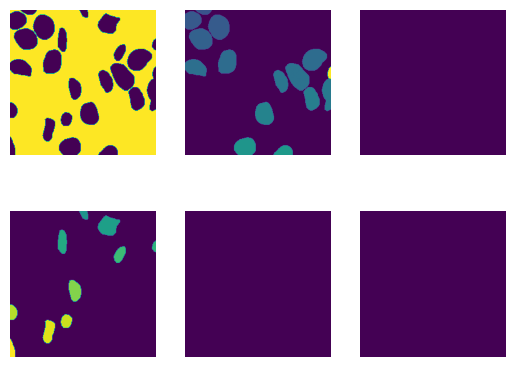

In [ ]:
visualize_mask_data(y_train, 0)

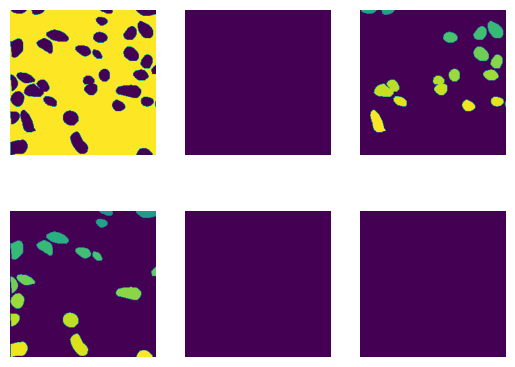

In [ ]:
visualize_mask_data(y_train, 2)

We will only use last (5) channel masks for binary mask creation

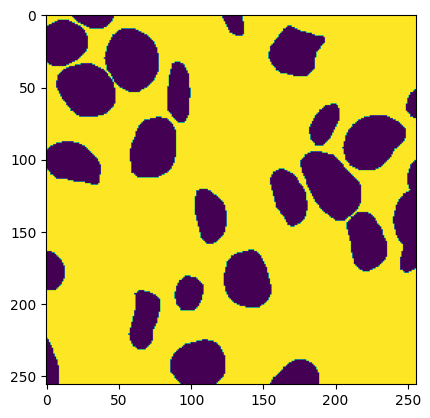

In [ ]:
plt.imshow(y_train[0,:,:,5])

In [ ]:
y_train = y_train[:,:,:,5]  # Mask array shape (60, 256, 256, 6), convert it to the (60, 256, 256, 1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = y_test[:,:,:,5]  # Mask array shape (60, 256, 256, 6), convert it to the (60, 256, 256, 1)
y_test = tf.expand_dims(y_test, axis=-1)

print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (540, 256, 256, 3)
X_test.shape:  (60, 256, 256, 3)
y_train.shape:  (540, 256, 256, 1)
y_test.shape:  (60, 256, 256, 1)


In [ ]:
print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')
print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

X_train min: 0.0, X_train max: 255.0, X_test min: 0.0, X_test max: 255.0
y_train min: 0.0, y_train max: 1.0, y_test min: 0.0, y_test max: 1.0


We need to normalize/scale Mask images into [0,1]

In [ ]:
normalize = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

y_train = normalize(y_train)
y_test = normalize(y_test)

print(f'y_train min: {np.min(y_train)}, y_train max: {np.max(y_train)}, y_test min: {np.min(y_test)}, y_test max: {np.max(y_test)}')

y_train min: 0.0, y_train max: 1.0, y_test min: 0.0, y_test max: 1.0


Normalize train and test images

In [ ]:
X_train = normalize(X_train)
X_test = normalize(X_test)

print(f'X_train min: {np.min(X_train)}, X_train max: {np.max(X_train)}, X_test min: {np.min(X_test)}, X_test max: {np.max(X_test)}')

X_train min: 0.0, X_train max: 1.0, X_test min: 0.0, X_test max: 1.0


Convert RGB mask images to binary mask images

In [ ]:
def rgb_to_gray(images):
  return np.dot(images[..., :3], [0.299, 0.587, 0.114])

In [ ]:
def convert_rgb_to_binary_mask(images):
  #images = tf.image.rgb_to_grayscale(images).numpy()  # or use rgb_to_gray(images)
  if type(images) != np.ndarray:
    images = images.numpy()
  images[images > 0.0] = 1.0
  return images

In [ ]:
y_train = convert_rgb_to_binary_mask(y_train)
y_test = convert_rgb_to_binary_mask(y_test)

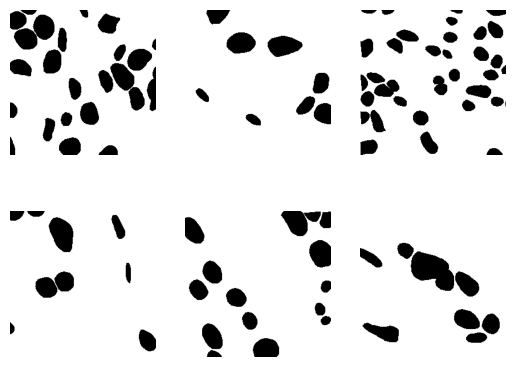

In [ ]:
for ix, image in enumerate(y_train[:6]):
    plt.subplot(2, 3, ix + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

We need to invert binary mask

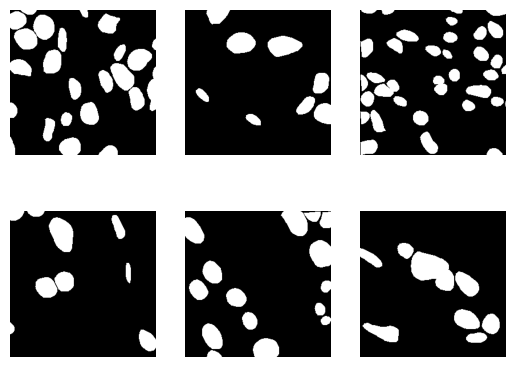

In [ ]:
y_train = np.invert(y_train)
y_test = np.invert(y_test)

for ix, image in enumerate(y_train[:6]):
    plt.subplot(2, 3, ix + 1)
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
INPUT_SHAPE = (256, 256, 3)
NUM_LABELS = 1  #Binary
BATCH_SIZE = 8
EPOCHS = 50

FILTER_NUM = 64   # number of filters for the conv layer
FILTER_SIZE = 3   # size of the convolutional filter (3,3)
UP_SAMP_SIZE = 2  # size of upsampling filters

In [ ]:
def create_dataset_pipeline(tensor, batch_size, shuffle=False):
    # Read images from directory and reshape, scale
    dataset = tf.data.Dataset.from_tensor_slices(tensor)

    # Shuffle (only training set) and create batches
    if shuffle == True:
        dataset = dataset.shuffle(len(tensor))
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
X_train_data = create_dataset_pipeline(X_train, BATCH_SIZE)
X_test_data = create_dataset_pipeline(X_test, BATCH_SIZE)
y_train_data = create_dataset_pipeline(y_train, BATCH_SIZE)
y_test_data = create_dataset_pipeline(y_test, BATCH_SIZE)

In [ ]:
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of X_train_data batches: {len(X_train_data)}")
print(f"Number of X_test_data batches: {len(X_test_data)}")
print(f"Number of y_train_data batches: {len(y_train_data)}")
print(f"Number of y_test_data batches: {len(y_test_data)}")

Batch Size: 8
Number of X_train_data batches: 68
Number of X_test_data batches: 8
Number of y_train_data batches: 68
Number of y_test_data batches: 8


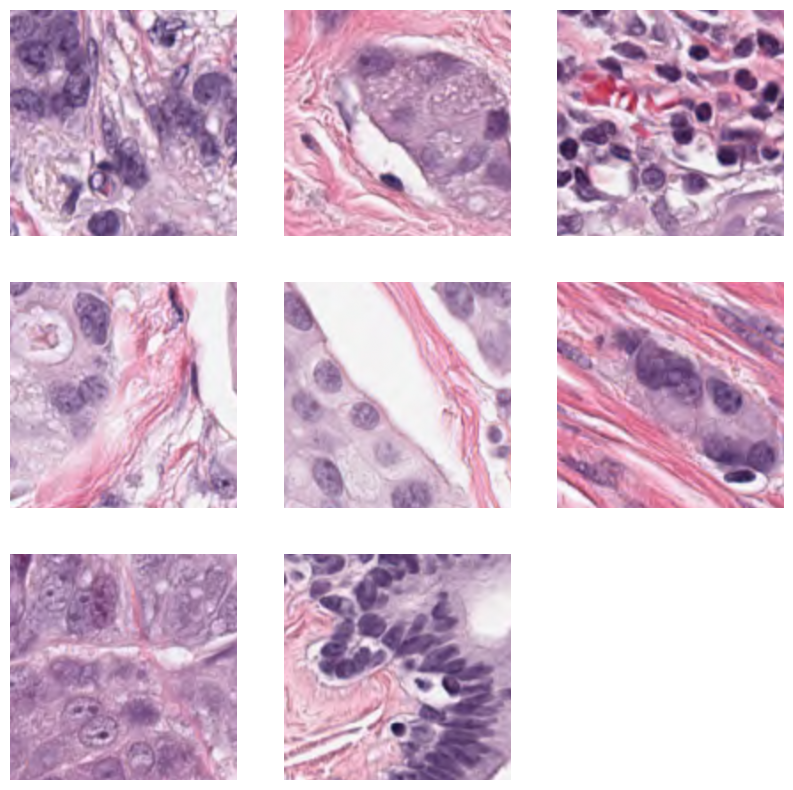

In [ ]:
vision.show_image_samples_from_batch(X_train_data, grid=(3,3))

### Training U-Net Model

In [ ]:
att_res_unet_model = Attention_ResUNet(input_shape=INPUT_SHAPE, filter_size=FILTER_SIZE, filter_num=FILTER_NUM, up_sample_size=UP_SAMP_SIZE, num_classes=NUM_LABELS, verbose=1)

Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normali

In [ ]:
att_res_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                   loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2),
                   metrics=['accuracy', jacard_coef_loss])

In [ ]:
len(X_train)

540

In [ ]:
import datetime

start = datetime.datetime.now()

att_res_unet_model_hist = att_res_unet_model.fit(X_train, y_train,
                                  verbose=1, batch_size=BATCH_SIZE,
                                  validation_data=(X_test, y_test), shuffle=False,
                                  epochs=EPOCHS)
end = datetime.datetime.now()
att_res_unet_model.save('cancer_instance_seg_att_res_unet_50_epochs.hdf5')
print(f"U-Net training time: {end-start}")

Epoch 1/50
68/68 [==============================] - 62s 915ms/step - loss: 0.0493 - accuracy: 0.9208 - jacard_coef_loss: -0.2899 - val_loss: 0.0561 - val_accuracy: 0.9052 - val_jacard_coef_loss: -0.2462
Epoch 2/50
68/68 [==============================] - 48s 706ms/step - loss: 0.0474 - accuracy: 0.9235 - jacard_coef_loss: -0.2993 - val_loss: 0.0531 - val_accuracy: 0.9097 - val_jacard_coef_loss: -0.2490
Epoch 3/50
68/68 [==============================] - 48s 709ms/step - loss: 0.0460 - accuracy: 0.9257 - jacard_coef_loss: -0.3079 - val_loss: 0.0511 - val_accuracy: 0.9121 - val_jacard_coef_loss: -0.2822
Epoch 4/50
68/68 [==============================] - 48s 707ms/step - loss: 0.0451 - accuracy: 0.9274 - jacard_coef_loss: -0.3147 - val_loss: 0.0580 - val_accuracy: 0.8857 - val_jacard_coef_loss: -0.2591
Epoch 5/50
68/68 [==============================] - 47s 694ms/step - loss: 0.0442 - accuracy: 0.9286 - jacard_coef_loss: -0.3215 - val_loss: 0.0757 - val_accuracy: 0.8549 - val_jacard_coef

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


U-Net training time: 0:40:03.763952


In [ ]:
import pandas as pd

att_unet_model_hist_df = pd.DataFrame(att_res_unet_model_hist.history)

with open('att_unet_model_hist_df.csv', mode='w') as f:
    att_unet_model_hist_df.to_csv(f)

### Plot the training and validation accuracy and loss at each epoch

In [ ]:
def plot_loss_curves(history):
  fig = plt.figure(figsize=(10,10))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['jacard_coef_loss']
  val_acc = history.history['val_jacard_coef_loss']

  epochs = range(1, len(loss) + 1)

  # Training and Validation Loss Graph
  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Jacard Loss Graph
  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'y', label='Training Jacard')
  plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
  plt.title('Training and validation Jacard')
  plt.xlabel('Epochs')
  plt.ylabel('Jacard')
  plt.legend()

  plt.show()

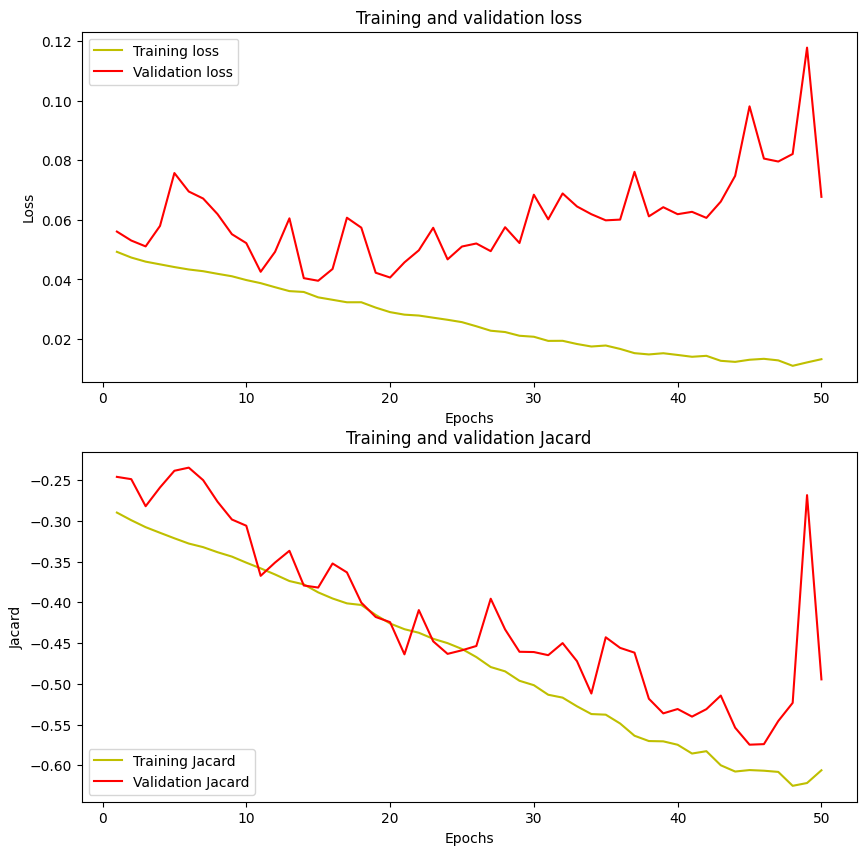

In [ ]:
plot_loss_curves(att_res_unet_model_hist)

In [ ]:
MODEL_PATH = '/content/cancer_instance_seg_att_res_unet_50_epochs.hdf5'

In [ ]:
# Load the model for testing
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

In [ ]:
TEST_IMG_IX = 2

In [ ]:
test_img = X_test[TEST_IMG_IX]
ground_truth_mask = y_test[TEST_IMG_IX]

test_img_input=np.expand_dims(test_img, 0)
prediction_mask = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 786ms/step


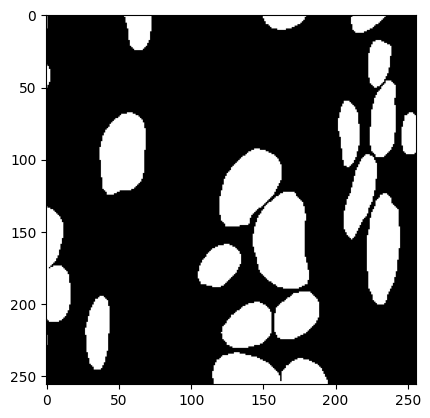

In [ ]:
plt.imshow(y_test[3,:, :,0], cmap='gray')

In [ ]:
def show_prediction_masks():
  ix = 0

  plt.figure(figsize=(12, 10))
  while ix < 9:
    plt.subplot(3, 3, (ix+1))
    plt.title('Testing Image')
    plt.imshow(X_test[ix], cmap='gray')

    plt.subplot(3, 3, (ix+2))
    plt.title('Testing Label')
    plt.imshow(y_test[ix,:, :,0], cmap='gray')

    plt.subplot(3, 3, (ix+3))
    plt.title('Prediction on test image')
    plt.imshow((model.predict(np.expand_dims(X_test[ix], 0))[0,:,:,0] > 0.5).astype(np.uint8), cmap='gray')

    ix = (ix+3)

  plt.show()

1/1 [==============================] - 0s 45ms/step


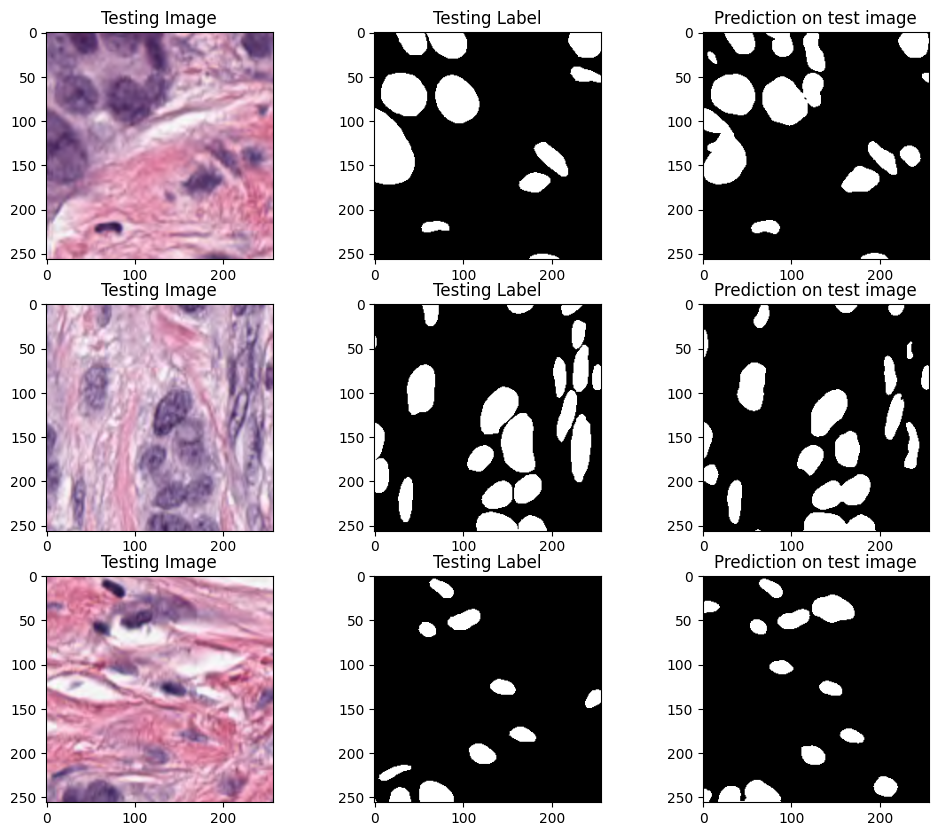

In [ ]:
show_prediction_masks()

### IoU (Intersection over Union) Calculation for single test image

In [ ]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth_mask[:,:,0], prediction_mask)

print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9007647


### Calculate IoU for all test images and calculate Avg. IoU

In [ ]:
import pandas as pd

def calculate_IoU_of_test_dataset(model, X_test, y_test, n_classes=2):
  IoU_values = []

  for ix, test_img in enumerate(X_test):
    ground_truth = y_test[ix]
    temp_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)
    #print(IoU)

  df = pd.DataFrame(IoU_values, columns=["IoU"])
  #df = df[df.IoU != 1.0]
  mean_IoU = df.mean().values
  print("Mean IoU is: ", str(mean_IoU))

In [ ]:
calculate_IoU_of_test_dataset(att_res_unet_model, X_test, y_test)

1/1 [==============================] - 0s 25ms/step
Mean IoU is:  [0.8025855]


### Reference

Original Paper: [Attention U-Net: Learning Where to Look for the Pancreas](https://arxiv.org/pdf/1804.03999.pdf)

https://github.com/bnsreenu/python_for_microscopists

https://github.com/bnsreenu/python_for_microscopists/blob/master/224_225_226_models.py

[224 - Recurrent and Residual U-net](https://www.youtube.com/watch?v=7aDOtKN2cJs) by DigitalSreeni

[225 - Attention U-net. What is attention and why is it needed for U-Net? ](https://www.youtube.com/watch?v=KOF38xAvo8I) by DigitalSreeni

[226 - U-Net vs Attention U-Net vs Attention Residual U-Net - should you care? ](https://www.youtube.com/watch?v=L5iV5BHkMzM) by DigitalSreeni